# TD CNN simple

Cours de Julien VELCIN pour le Master MALIA

cf. : https://medium.com/@nutanbhogendrasharma/pytorch-convolutional-neural-network-with-mnist-dataset-4e8a4265e118 

In [1]:
import torch 
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from custom_functions import summary, evaluate_model

## Chargement des données

On va télécharger le jeu de données ultra-classique MNIST qui est fourni clef en main avec la librairie torchvision.

In [2]:
from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

Quelques affichages pour s'assurer que tout est ok.

In [3]:
print(train_data)
print(f"Taille des données : {train_data.data.size()}")
print(f"Classes : {train_data.targets.size()}")

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Taille des données : torch.Size([60000, 28, 28])
Classes : torch.Size([60000])


In [4]:
print(test_data)
print(f"Taille des données : {test_data.data.size()}")
print(f"Classes : {test_data.targets.size()}")

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()
Taille des données : torch.Size([10000, 28, 28])
Classes : torch.Size([10000])


On peut bien sûr accéder aux données et afficher quelques chiffres

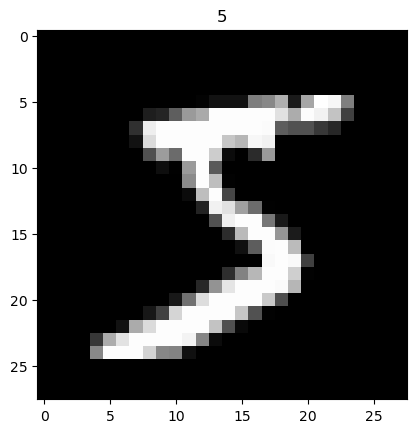

In [5]:
plt.imshow(train_data.data[0], cmap='gray')
plt.title('%i' % train_data.targets[0])
plt.show()

Affichons à présent un échantillon des données :

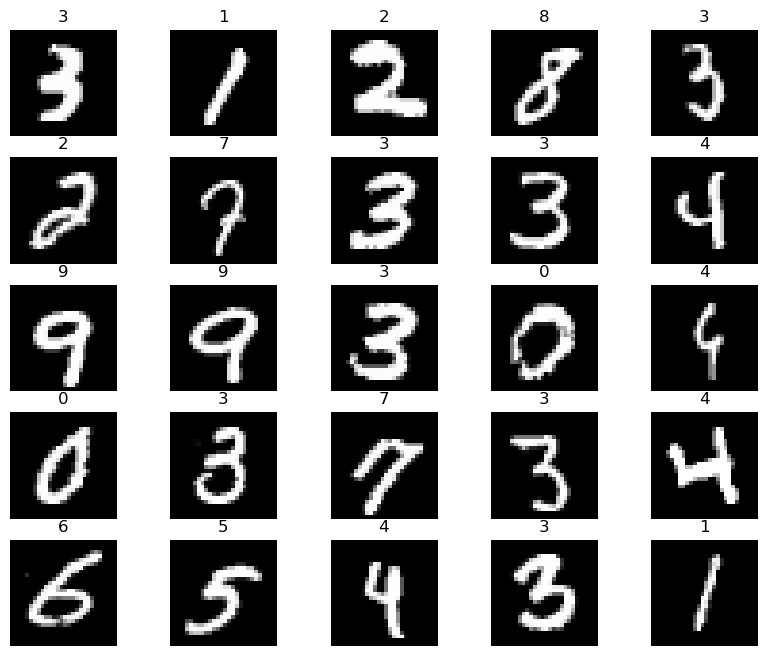

In [6]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

On va séparer le jeu d'entraînement en deux sous-ensembles : train et validation.

In [7]:
BATCH_SIZE = 100 # taille des batch (100 images par 100 images)

# On partage les 60k en 50k pour le train et 10k pour la validation
train_subset, val_subset = torch.utils.data.random_split(
        train_data, [50000, 10000], generator=torch.Generator().manual_seed(1))

# On crée les Dataset pour Pytorch
X_train = train_subset.dataset.data[train_subset.indices]
y_train = train_subset.dataset.targets[train_subset.indices]
X_val = val_subset.dataset.data[val_subset.indices]
y_val = val_subset.dataset.targets[val_subset.indices]

# Enfin on crée les DataLoader correspondant
train_loader = DataLoader(dataset=train_subset, shuffle=True, batch_size=BATCH_SIZE)
val_loader = DataLoader(dataset=val_subset, shuffle=False, batch_size=BATCH_SIZE)
test_loader = DataLoader(dataset=test_data, shuffle=True, batch_size=BATCH_SIZE)

## Définition du modèle

Il s'agit d'un modèle simple à 2 couches CNN avec du MaxPooling.

In [14]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # 1ère couche de convolution
        self.conv1 = torch.nn.Sequential(         
            torch.nn.Conv2d(
                in_channels=1,  # 1 canal = niveaux de gris
                out_channels=16,  # 16 canaux (filtres) en sortie
                kernel_size=5,  # taille du noyau = 5x5
                stride=1,  # décalage de 1
                padding=2, # padding de 2 pour avoir la même taille en sortie  
            ),                              
            torch.nn.ReLU(),                      
            torch.nn.MaxPool2d(kernel_size=2), # maxPooling 2x2 avec stride 2
        )
        # 2ème couche de convolution
        self.conv2 = torch.nn.Sequential(         
            torch.nn.Conv2d(16, 32, 5, 1, 2),     # on ne détaille plus...
            torch.nn.ReLU(),                      
            torch.nn.MaxPool2d(2), # maxPooling 2x2
        )
        # couche linéaire avec 10 neurones de sortie
        self.out = torch.nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # applatit (flatten) le tenseur : (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    

In [15]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


Affichage de l'architecture avec une fonction "maison" :

In [16]:
summary(cnn)

Couche 0: [16, 1, 5, 5] (400 paramètres entrainables)
Couche 1: [16] (16 paramètres entrainables)
Couche 2: [32, 16, 5, 5] (12800 paramètres entrainables)
Couche 3: [32] (32 paramètres entrainables)
Couche 4: [10, 1568] (15680 paramètres entrainables)
Couche 5: [10] (10 paramètres entrainables)
  = 28938 paramètres entrainables


Deux couches de filtres avec resp. 16 et 32 noyaux :
* Noyau 1 : 16x1x5x5 = 400 paramètres + 16 de biais
* Noyau 2 : 32x16x5x5 = 12800 paramètres + 32 de biais
Les deux opérations de MaxPooling (2x2, avec stride 2) réduit la taille des images à 7x7
Enfin, on applatit tout : 32 canaux x 7x7 = 1568 entrées
La couche linéaire a donc : 1568x10 = 15680 paramètres + 10 de biais

Il ne reste plus qu'à choisir la fonction de coût (ici une *cross entropy* classique en classification) et l'optimiseur (Adam, avec pas d'apprentissage de 0.1).

In [17]:
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr = 0.01)   

## Lancer l'apprentissage

In [18]:
Nepochs = 1 # Nombre d'époques (Nombre de passes sur toutes les données) 

for epoch in range(Nepochs):
    for batch_idx, (data, target) in enumerate(train_loader): # 1 batch
        cnn.train() # permet de s'assurer qu'on est en mode "apprentissage"
        optimizer.zero_grad()   ## réinitialiser les gradients (IMPORTANT !)
        output = cnn(data)[0]  # lance l'inférence
        loss = loss_func(output, target)
        loss.backward()  # backpropagation à travers le réseau       
        optimizer.step() # mise à jour des paramètres du réseau ( w = w -lr * w.grad) équivalent à une itération du SGD
        if (batch_idx+1) % 10 == 0:
            acc_val = evaluate_model(cnn, val_loader)
            print ('Epoch [{}], Step [{}], Loss: {:.4f}, Val: {:.2%}' .format(epoch + 1, batch_idx + 1, loss.item(), acc_val))
        if batch_idx == 150:
            break # on arrête ici à 150 batch (ie 15000 images) car ça suffit largement

Epoch [1], Step [10], Loss: 1.1797, Val: 64.59%
Epoch [1], Step [20], Loss: 0.6882, Val: 83.31%
Epoch [1], Step [30], Loss: 0.5037, Val: 89.39%
Epoch [1], Step [40], Loss: 0.1128, Val: 90.43%
Epoch [1], Step [50], Loss: 0.1575, Val: 92.69%
Epoch [1], Step [60], Loss: 0.2514, Val: 94.80%
Epoch [1], Step [70], Loss: 0.0776, Val: 95.21%
Epoch [1], Step [80], Loss: 0.1589, Val: 93.81%
Epoch [1], Step [90], Loss: 0.1730, Val: 94.68%
Epoch [1], Step [100], Loss: 0.0648, Val: 95.62%
Epoch [1], Step [110], Loss: 0.0882, Val: 96.07%
Epoch [1], Step [120], Loss: 0.0853, Val: 96.11%
Epoch [1], Step [130], Loss: 0.1157, Val: 96.37%
Epoch [1], Step [140], Loss: 0.0633, Val: 94.74%
Epoch [1], Step [150], Loss: 0.1038, Val: 94.83%


Calcul de l'accuracy sur le jeu de tests :

In [19]:
acc_test = evaluate_model(cnn, test_loader)
print(acc_test)

0.9528
